In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#taking first 4 characters as cpc class
long_merge_data = pd.read_csv('long_merge.csv')

long_merge_data['cpc'] = long_merge_data['cpc'].astype(str).str[:4]

filtered_df = long_merge_data.drop('Unnamed: 0', axis=1)
filtered_df

In [ ]:
# creating a table with time intervals for permno and cpc
merged_df = filtered_df
merged_df['issue_date'] = pd.to_datetime(merged_df['issue_date'], format='%Y%m%d')
merged_df['issue_date'] = merged_df['issue_date'].dt.year

# find min and max issue date to split up data
min_issue_date = merged_df['issue_date'].min() # 1926
max_issue_date = merged_df['issue_date'].max() # 2022

# create time intervals of 5 years
interval_range = pd.IntervalIndex.from_tuples([(year, year + 5) for year in range(min_issue_date, max_issue_date + 1, 5)], closed='left')

# add intervals into table
merged_df['5_year_interval'] = pd.cut(merged_df['issue_date'], bins=interval_range)

# create unique rows with every combination of permno, 5 year interval and cpc, and count cpc occurrence based on same permno and interval
result_df = merged_df.groupby(['permno', '5_year_interval', 'cpc']).size().reset_index(name='cpc_count')

#drop the NaN cpc rows
result_df.dropna(subset=['cpc'], inplace=True)
result_df = result_df[result_df['cpc_count'] != 0]
result_df

In [2]:
interval_df = pd.read_csv('cpc_date_intervals.csv')
interval_df.drop("Unnamed: 0", axis=1, inplace=True)
interval_df = interval_df.rename(columns={'cpc_count': 'by_cpc_count'})

# find the total number of cpcs for each row with the same permno and interval
interval_df['total'] = interval_df.groupby(['permno', '5_year_interval'])['by_cpc_count'].transform('sum')

# for each firm calculate the denominator
interval_df['cpc_ratio_squared'] = (interval_df['by_cpc_count']/interval_df['total'])**2

# firm denominator is going to stay the same with for each firm
interval_df['denominator'] = interval_df.groupby(['permno', '5_year_interval'])['cpc_ratio_squared'].transform('sum')

interval_df['unique_cpc'] = interval_df.groupby(['permno', '5_year_interval'])['cpc'].transform('nunique')
interval_df

,permno,5_year_interval,cpc,by_cpc_count,total,cpc_ratio_squared,denominator,unique_cpc
0,10001,"[1991, 1996)",F03D,1,8,0.015625,0.437500,4
1,10001,"[1991, 1996)",Y02E,1,8,0.015625,0.437500,4
2,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.437500,4
3,10001,"[1991, 1996)",Y10T,5,8,0.390625,0.437500,4
4,10001,"[1996, 2001)",A61F,2,3,0.444444,0.555556,2
...,...,...,...,...,...,...,...,...
522829,93436,"[2016, 2021)",Y02E,8,337,0.000564,0.113508,39
522830,93436,"[2016, 2021)",Y02T,40,337,0.014088,0.113508,39
522831,93436,"[2016, 2021)",Y04S,2,337,0.000035,0.113508,39
522832,93436,"[2016, 2021)",Y10S,1,337,0.000009,0.113508,39


In [3]:
merged_df = interval_df.merge(interval_df, on=['5_year_interval', 'cpc'], suffixes=('_1', '_2'))

# filter out rows where permno1 is the same as permno2 to get rid of duplicates
merged_df = merged_df[merged_df['permno_1'] != merged_df['permno_2']]

# get the numerator product for each permno pair
merged_df['numerator'] = (merged_df['by_cpc_count_1'] / merged_df['total_1']) * (merged_df['by_cpc_count_2']/merged_df['total_2'])
merged_df['numerator_sum'] = merged_df.groupby(['permno_1', 'permno_2', '5_year_interval'])['numerator'].transform('sum')
merged_df['tech_dist'] = merged_df['numerator_sum'] / (np.sqrt(merged_df['denominator_1']) * np.sqrt(merged_df['denominator_2']))
merged_df

,permno_1,5_year_interval,cpc,by_cpc_count_1,total_1,cpc_ratio_squared_1,denominator_1,unique_cpc_1,permno_2,by_cpc_count_2,total_2,cpc_ratio_squared_2,denominator_2,unique_cpc_2,numerator,numerator_sum,tech_dist
1,10001,"[1991, 1996)",F03D,1,8,1.562500e-02,0.437500,4,26454,18,1702,1.118474e-04,0.038015,101,1.321974e-03,0.032095,0.248866
2,26454,"[1991, 1996)",F03D,18,1702,1.118474e-04,0.038015,101,10001,1,8,1.562500e-02,0.437500,4,1.321974e-03,0.032095,0.248866
5,10001,"[1991, 1996)",Y02E,1,8,1.562500e-02,0.437500,4,10145,40,6380,3.930779e-05,0.025288,244,7.836991e-04,0.067535,0.642073
6,10001,"[1991, 1996)",Y02E,1,8,1.562500e-02,0.437500,4,10382,1,139,5.175716e-05,0.269085,21,8.992806e-04,0.004496,0.013105
7,10001,"[1991, 1996)",Y02E,1,8,1.562500e-02,0.437500,4,10401,2,224,7.971939e-05,0.064373,43,1.116071e-03,0.035156,0.209489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81337600,92157,"[2021, 2026)",B61G,1,2100,2.267574e-07,0.250845,106,81677,1,406,6.066636e-06,0.077617,56,1.172883e-06,0.013683,0.098061
81337609,86110,"[2001, 2006)",F22G,1,1991,2.522653e-07,0.035707,128,88935,1,24252,1.700219e-09,0.023989,326,2.071005e-08,0.011705,0.399942
81337610,88935,"[2001, 2006)",F22G,1,24252,1.700219e-09,0.023989,326,86110,1,1991,2.522653e-07,0.035707,128,2.071005e-08,0.011705,0.399942
81337615,87499,"[2006, 2011)",C12F,1,1125,7.901235e-07,0.098185,49,90439,1,450,4.938272e-06,0.062874,53,1.975309e-06,0.005090,0.064788


In [4]:
# write to csv 
merged_df.to_csv('technological_dist.csv')

#sorted_df = merged_df.sort_values(by=['permno_1', '5_year_interval', 'permno_2'])

In [5]:
pd.set_option('display.max_rows', None)
row100 = sorted_df.head(100)
row100

# change column names to be more informative -> firm_calc_1 ??
# cpc_count_1 -> by_cpc_count_1
# insert two new columns: unique_cpc_1 and unique_cpc_2, will be the same for each permno, 5 year interval
# send code + csv
# do some exploration, find more patents, observations and visualization, tech distance between this firm vs other firm, bubble graph?


,permno_1,5_year_interval,cpc,cpc_count_1,total_1,firm_calc_1,firm_denom_1,permno_2,cpc_count_2,total_2,firm_calc_2,firm_denom_2,numerator,numerator_sum,tech_dist
1136023,10001,"[1991, 1996)",Y10T,5,8,0.390625,0.4375,10057,4,23,3.024575e-02,0.187146,0.108696,0.108696,0.379869
18774,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,10078,24,826,8.442331e-04,0.162808,0.003632,0.016495,0.061806
1136024,10001,"[1991, 1996)",Y10T,5,8,0.390625,0.4375,10078,17,826,4.235822e-04,0.162808,0.012863,0.016495,0.061806
18775,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,10087,1,9,1.234568e-02,0.432099,0.013889,0.013889,0.031944
18776,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,10095,2,32,3.906250e-03,0.373047,0.007812,0.007812,0.019338
18777,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,10104,4,9,1.975309e-01,0.506173,0.055556,0.055556,0.118056
18778,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,10107,24,322,5.555341e-03,0.272250,0.009317,0.009317,0.026996
1136025,10001,"[1991, 1996)",Y10T,5,8,0.390625,0.4375,10128,4,41,9.518144e-03,0.258775,0.060976,0.060976,0.181220
1136026,10001,"[1991, 1996)",Y10T,5,8,0.390625,0.4375,10142,12,41,8.566330e-02,0.188578,0.182927,0.182927,0.636858
18779,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,10143,1,32,9.765625e-04,0.337891,0.003906,0.003906,0.010160


In [5]:
tech_dist = pd.read_csv('technological_dist.csv')
sorted_df = tech_dist.sort_values(by=['permno_1', '5_year_interval', 'permno_2'])
sorted_df.head(100)

: 

: 

In [7]:
min_val = merged_df['tech_dist'].min()
max_val = merged_df['tech_dist'].max()

mean_val = merged_df['tech_dist'].mean()
median_val = merged_df['tech_dist'].median()
percentile25 = merged_df['tech_dist'].quantile(0.25)
percentile75 = merged_df['tech_dist'].quantile(0.75)

print("Min: ", min_val)
print("Max: ", max_val)
print("Mean: ", mean_val)
print("Median: ", median_val)
print("25th Percentile: ", percentile25)
print("75th Percentile: ", percentile75)

Min:  9.046358402287053e-08
Max:  1.0000000000000002
Mean:  0.18414627561296013
Median:  0.09914351799266875
25th Percentile:  0.027189524535074214
75th Percentile:  0.26754996281615345


In [10]:
min_value_row = merged_df.loc[merged_df['tech_dist'].idxmin()].to_frame().T
max_value_row = merged_df.loc[merged_df['tech_dist'].idxmax()].to_frame().T


,permno_1,5_year_interval,cpc,cpc_count_1,total_1,firm_calc_1,firm_denom_1,permno_2,cpc_count_2,total_2,firm_calc_2,firm_denom_2,numerator,numerator_sum,tech_dist
2457853,52695,"[2001, 2006)",Y10S,12,14,0.734694,0.755102,76456,6,7,0.734694,0.755102,0.734694,0.755102,1.0


In [13]:
merged_df[(merged_df['permno_1'] == 10001) & (merged_df['permno_2'] == 26454)]

,permno_1,5_year_interval,cpc,cpc_count_1,total_1,firm_calc_1,firm_denom_1,permno_2,cpc_count_2,total_2,firm_calc_2,firm_denom_2,numerator,numerator_sum,tech_dist
1,10001,"[1991, 1996)",F03D,1,8,0.015625,0.4375,26454,18,1702,0.000112,0.038015,0.001322,0.032095,0.248866
70,10001,"[1991, 1996)",Y02E,1,8,0.015625,0.4375,26454,8,1702,0.000022,0.038015,0.000588,0.032095,0.248866
19078,10001,"[1991, 1996)",Y10S,1,8,0.015625,0.4375,26454,36,1702,0.000447,0.038015,0.002644,0.032095,0.248866
1136277,10001,"[1991, 1996)",Y10T,5,8,0.390625,0.4375,26454,75,1702,0.001942,0.038015,0.027541,0.032095,0.248866


In [6]:
cpc_and_counts = merged_df[['patent_num', 'cpc', 'count']]
cpc_and_counts.sort_values(by='count')

,patent_num,cpc,count
4077796,11540239,H04B,2
1465573,5932937,Y10T,2
1465572,5932908,G11C,2
1465571,5932908,H01L,2
2987701,9164067,G01N,2
...,...,...,...
3726127,10723306,B65G,38
3726126,10723306,B66F,38
3726125,10723306,E02F,38
3726105,10723306,G02F,38


In [7]:
from itertools import combinations
# Concatenate all CPC values for each patent number into a single string
grouped_df = cpc_and_counts.groupby('patent_num')['cpc'].apply(lambda x: ' '.join(x)).reset_index()

# Get all possible combinations of CPC values for each patent number
grouped_df['CPC_combinations'] = grouped_df['cpc'].apply(lambda x: list(combinations(x.split(), 2)))

# Flatten the list of combinations
flat_combinations = [pair for sublist in grouped_df['CPC_combinations'] for pair in sublist]

# Count the occurrences of each unique combination
combination_counts = pd.Series(flat_combinations).value_counts().reset_index()
combination_counts.columns = ['CPC_pair', 'Occurrences']


In [8]:
# Sort the tuples in the 'CPC_pair' column
combination_counts['CPC_pair'] = combination_counts['CPC_pair'].apply(lambda x: tuple(sorted(x)))

# Group by the sorted CPC pairs and aggregate the occurrences
grouped_df = combination_counts.groupby('CPC_pair')['Occurrences'].sum().reset_index()

grouped_df.sort_values(by="Occurrences", ascending=False)
#grouped_df.to_csv('CPC_pair_Occurrences.csv')

,CPC_pair,Occurrences
56748,"(G06F, H04L)",64351
59691,"(H04L, H04W)",62914
59893,"(Y10S, Y10T)",34385
56673,"(G06F, G06Q)",26617
59615,"(H04B, H04L)",22244
...,...,...
42532,"(D01H, D06C)",1
42530,"(D01H, D05B)",1
42529,"(D01H, D04H)",1
42528,"(D01H, D04B)",1


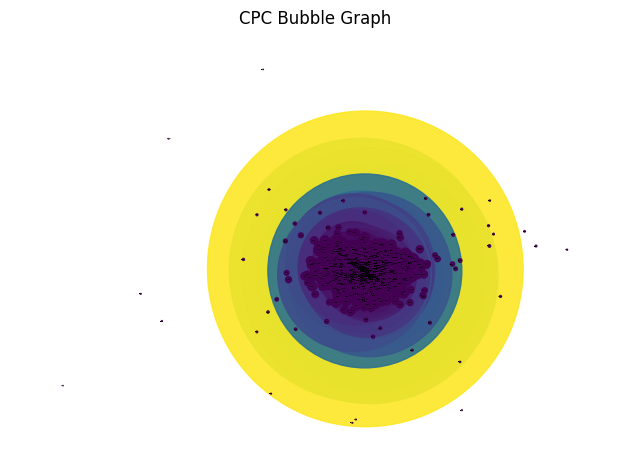

In [25]:

import networkx as nx
# Sort the tuples in the 'CPC_pair' column
grouped_df['CPC_pair'] = grouped_df['CPC_pair'].apply(lambda x: tuple(sorted(x)))

# Convert CPC pairs to unique strings for labels
grouped_df['CPC_pair_str'] = grouped_df['CPC_pair'].apply(lambda x: ', '.join(x))

# Create a networkx graph
G = nx.Graph()

# Add CPC nodes to the graph
for cpc in grouped_df['CPC_pair'].explode():
    G.add_node(cpc)

# Add CPC pair connections to the graph with 'weight' attribute
for _, row in grouped_df.iterrows():
    cpc_pair = row['CPC_pair']
    weight = row['Occurrences']
    G.add_edge(cpc_pair[0], cpc_pair[1], weight=weight)

# Calculate positions for the CPC nodes
pos = nx.spring_layout(G)

# Get edge weights for setting edge widths
edge_weights = [G.edges[edge]['weight'] for edge in G.edges]

# Get node sizes based on occurrences
node_sizes = [G.degree(node, weight='weight') * 0.1 for node in G.nodes]

# Use 'viridis' colormap for nodes
cmap = plt.get_cmap('viridis')

# Use 'viridis' colormap for nodes with a different color for each node
node_colors = [G.degree(node, weight='weight') for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='viridis', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[weight * 0.0005 for weight in edge_weights], edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=1, font_color='black', font_weight='bold')
plt.title('CPC Bubble Graph')
plt.axis('off')
plt.tight_layout()
plt.show()

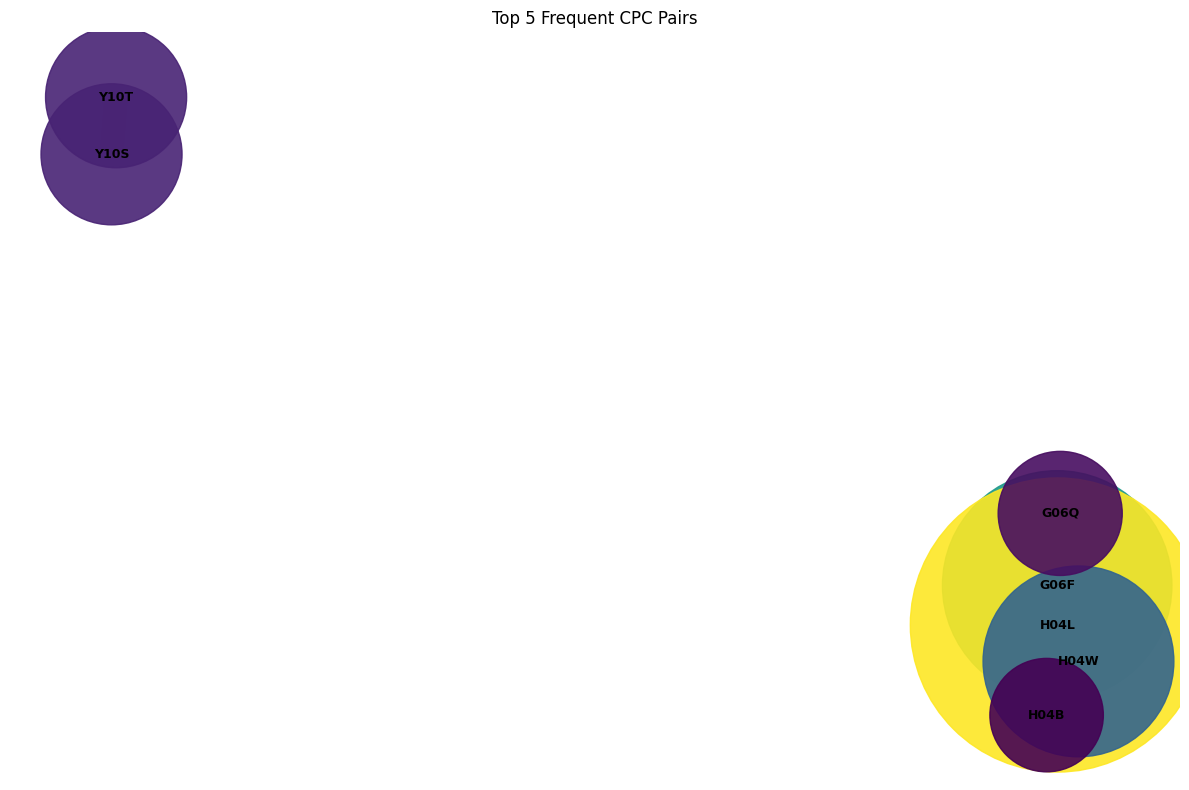

In [36]:
# Sort the tuples in the 'CPC_pair' column
grouped_df['CPC_pair'] = grouped_df['CPC_pair'].apply(lambda x: tuple(sorted(x)))

# Convert CPC pairs to unique strings for labels
grouped_df['CPC_pair_str'] = grouped_df['CPC_pair'].apply(lambda x: ', '.join(x))

grouped_df.sort_values(by='Occurrences', ascending=False, inplace=True)

# Select the top _ frequent CPC pairs
top_10_df = grouped_df.head(5)

# Create a networkx graph
G = nx.Graph()

# Add CPC nodes to the graph
for cpc in top_10_df['CPC_pair'].explode():
    G.add_node(cpc)

# Add CPC pair connections to the graph with 'weight' attribute
for _, row in top_10_df.iterrows():
    cpc_pair = row['CPC_pair']
    weight = row['Occurrences']
    G.add_edge(cpc_pair[0], cpc_pair[1], weight=weight)

# Calculate positions for the CPC nodes
pos = nx.spring_layout(G)

# Get edge weights for setting edge widths
edge_weights = [G.edges[edge]['weight'] for edge in G.edges]

# Rescale node sizes for better visibility
node_sizes = [G.degree(node, weight='weight') * 0.3 for node in G.nodes]

# Create the plot with a white background
plt.figure(figsize=(12, 8))
plt.gca().set_facecolor('white')

# Use 'viridis' colormap for nodes
cmap = plt.get_cmap('viridis')

# Use 'viridis' colormap for nodes with a different color for each node
node_colors = [G.degree(node, weight='weight') for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='viridis', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[weight * 0.0005 for weight in edge_weights], edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_color='black', font_weight='bold')
plt.title('Top 5 Frequent CPC Pairs')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# count number of patents with more than 1 cpc
patent_count = filtered_df['patent_num'].value_counts()
patent_nums_to_keep = patent_count[patent_count > 1]
patent_nums_to_keep = patent_nums_to_keep.reset_index()
patent_nums_to_keep.columns = ['patent_num', 'count']
patent_nums_to_keep

# add a column with cpc counts to the table
merged_df = filtered_df.merge(patent_nums_to_keep, how='inner', on='patent_num')
merged_df.sort_values(by='count', ascending=False)